In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY']      = 'your_kaggle_key'

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
# Data Handling
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Statistical Analysis
import statsmodels.api as sm
from scipy.stats import spearmanr

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix, precision_recall_curve
)

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)

api = KaggleApi()
api.authenticate()

api.competition_download_file('titanic', 'train.csv', path='.', force=True)
api.competition_download_file('titanic', 'test.csv',  path='.', force=True)

import pandas as pd
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')


100%|██████████| 59.8k/59.8k [00:00<00:00, 22.6MB/s]

100%|██████████| 28.0k/28.0k [00:00<00:00, 18.2MB/s]

In [4]:
# Classify variables into types based on their data type and context
classification = []

for column in train_data.columns:
    dtype = train_data[column].dtype
    if dtype == 'int64' or dtype == 'float64':
        # Check if column is numeric or boolean based on unique values
        unique_vals = train_data[column].dropna().unique()
        if len(unique_vals) <= 2:
            var_type = 'Boolean'
        else:
            var_type = 'Numeric'
    elif dtype == 'object':
        # Treat object type as categorical or ordinal based on context
        if 'Qual' in column or 'Cond' in column or 'Type' in column or 'Finish' in column:
            var_type = 'Ordinal'
        else:
            var_type = 'Category'
    else:
        var_type = 'Others'
    classification.append((column, var_type))

# Convert classification list to a DataFrame for better visualization
classification_df = pd.DataFrame(classification, columns=['Variable', 'Type'])

# Display the classification results without using tools
print(classification_df.head(20))  # Display first 20 rows for preview

classification_df.to_csv("classification_df.csv", index=False)



       Variable      Type
0   PassengerId   Numeric
1      Survived   Boolean
2        Pclass   Numeric
3          Name  Category
4           Sex  Category
5           Age   Numeric
6         SibSp   Numeric
7         Parch   Numeric
8        Ticket  Category
9          Fare   Numeric
10        Cabin  Category
11     Embarked  Category


In [5]:
row_count = len(train_data)
print(f"Number of rows: {row_count}")

Number of rows: 891


In [479]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [480]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [481]:
train_desc = train_data.describe()
train_desc

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [482]:
test_desc = test_data.describe()
test_desc

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Missing Data Summary:
          Missing Count  Missing Percentage (%)
Age                 177               19.865320
Cabin               687               77.104377
Embarked              2                0.224467


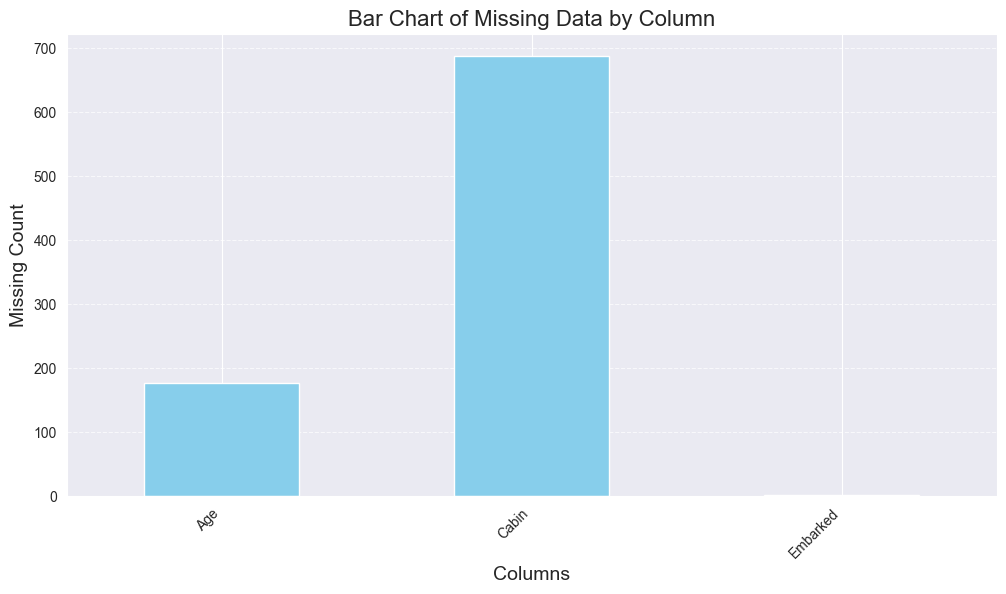


Outlier Summary:
       Outlier Count
Age               11
SibSp             46
Parch            213
Fare             116


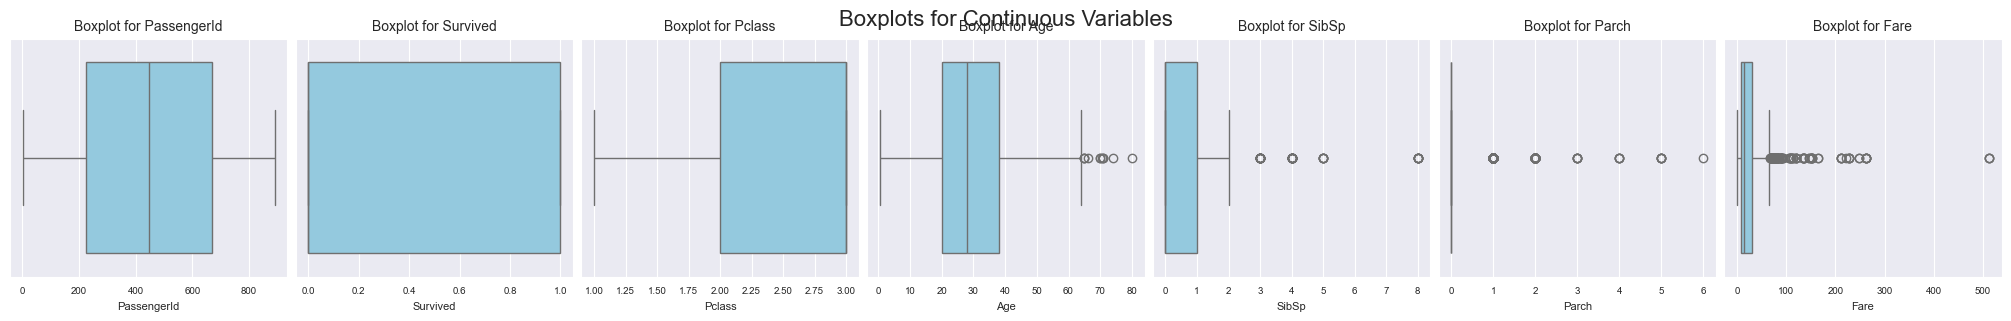

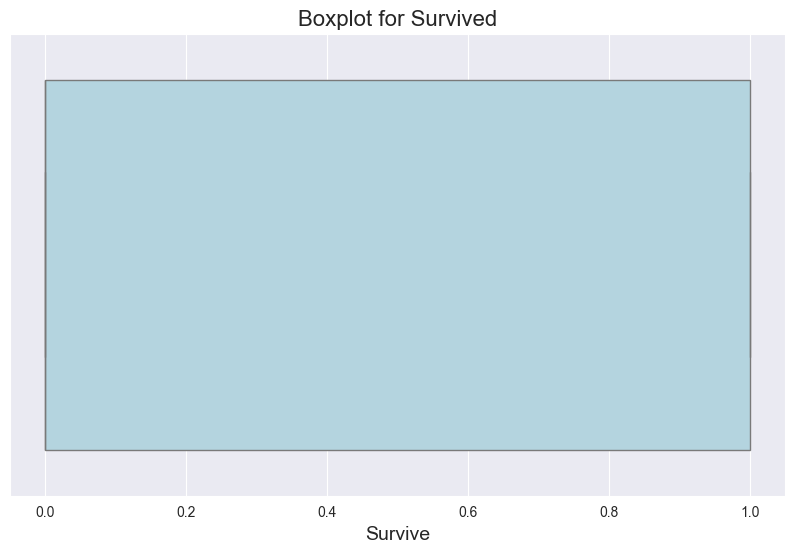

In [483]:
### THIS SESSION INVESTIGATES TRAIN DATA ###

### Step 1: Investigate Missing Values ###

# Calculate missing values for each column
missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

### Step 2: Investigate Outliers ###

# Use boxplots to identify outliers for continuous variables
continuous_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns

# Detect outliers using the IQR method
outlier_summary = {}
for column in continuous_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_data[(train_data[column] < lower_bound) | (train_data[column] > upper_bound)]
    outlier_count = len(outliers)
    outlier_summary[column] = outlier_count

# Display the outlier summary
outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_summary_df = outlier_summary_df[outlier_summary_df['Outlier Count'] > 0]  # Filter columns with outliers
print("\nOutlier Summary:")
print(outlier_summary_df)


def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    """
    Plot boxplots for all numeric columns in a DataFrame in a grid layout.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        max_rows (int): The maximum number of rows in the grid.
        max_cols (int): The maximum number of boxplots per row.
    """
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(train_data)

### Optional: Visualize Outliers' ###
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['Survived'], color='lightblue')
plt.title("Boxplot for Survived", fontsize=16)
plt.xlabel("Survive", fontsize=14)
plt.show()


Missing Data Summary:
       Missing Count  Missing Percentage (%)
Age               86               20.574163
Fare               1                0.239234
Cabin            327               78.229665


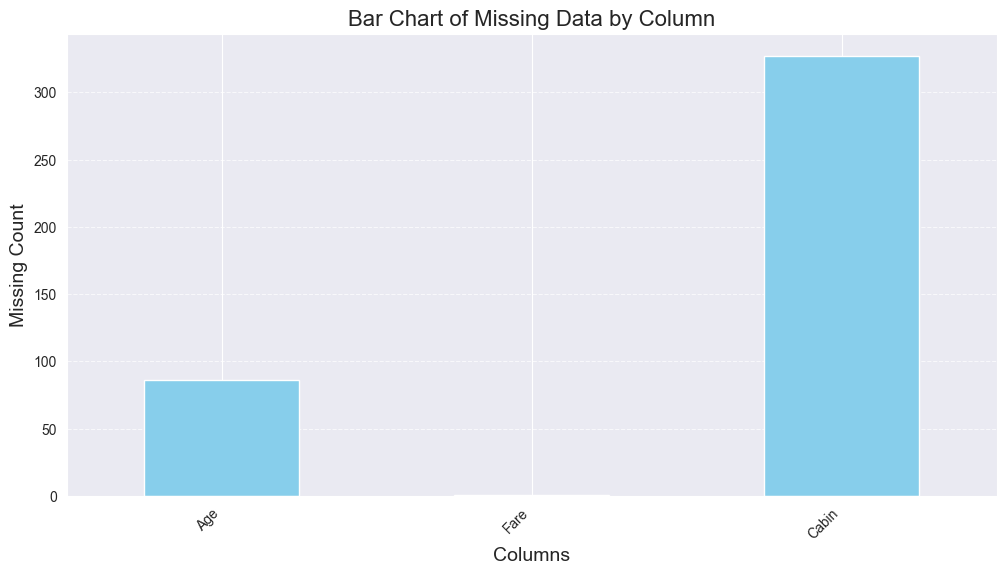

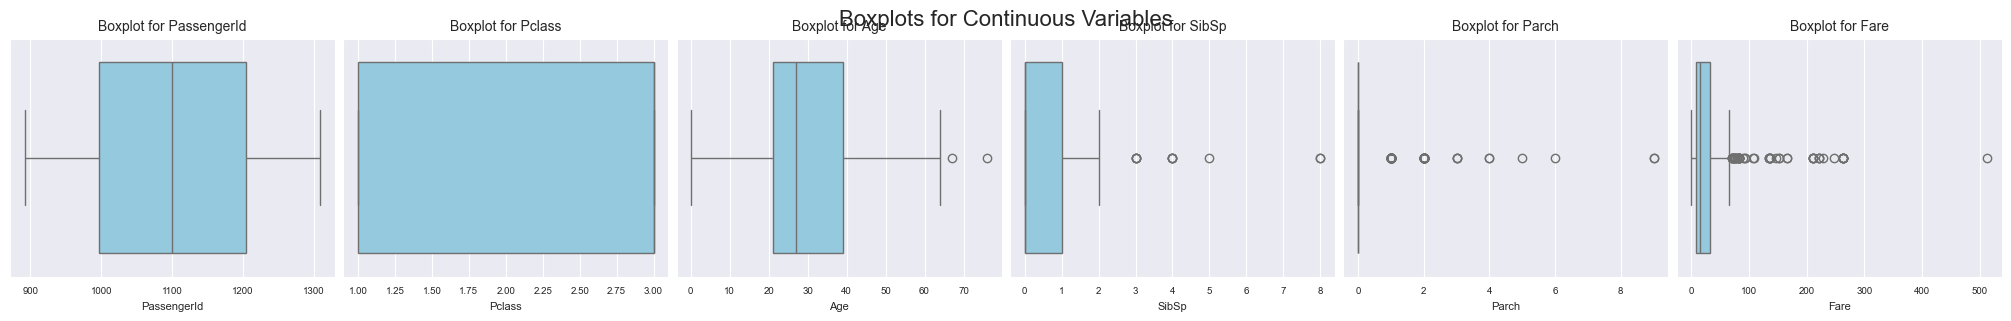

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


In [484]:
### THIS SESSION INVESTIGATES TEST DATA ###

### Step 1: Investigate Missing Values ###
# Calculate missing values for each column
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(test_data)

# Check # of row
print(test_data.info())


In [485]:
## Data Cleaning ##

test_data_id = test_data[['PassengerId']].copy()  # Retain PassengerId as a separate DataFrame

# Ensure correct column label
test_data_id.columns = ['PassengerId']

# Drop unnecessary columns only if they exist
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

# Handle missing values
train_data = train_data.assign(Age=train_data['Age'].fillna(train_data['Age'].median()))
test_data = test_data.assign(Age=test_data['Age'].fillna(test_data['Age'].median()))

train_data = train_data.assign(Embarked=train_data['Embarked'].fillna(train_data['Embarked'].mode()[0]))
test_data = test_data.assign(Embarked=test_data['Embarked'].fillna(test_data['Embarked'].mode()[0]))

train_data = train_data.assign(Fare=train_data['Fare'].fillna(train_data['Fare'].median()))
test_data = test_data.assign(Fare=test_data['Fare'].fillna(test_data['Fare'].median()))


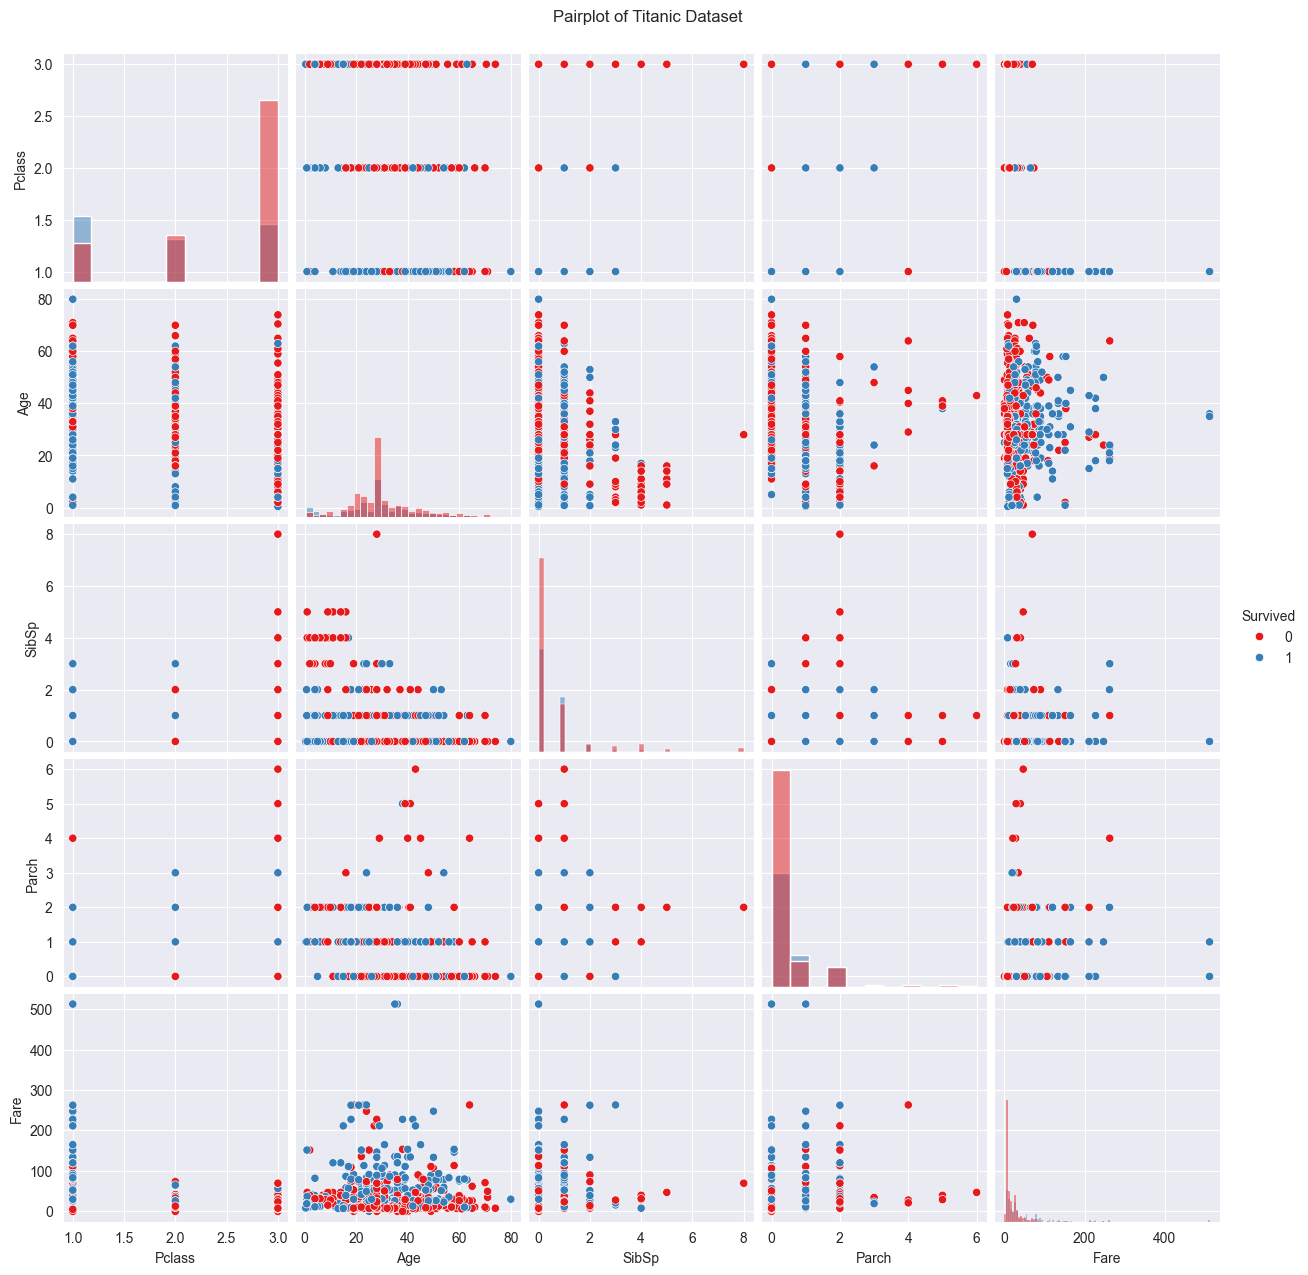

In [486]:
numeric_train_data = train_data.select_dtypes(include=['number'])  # Select only numeric columns

sns.pairplot(numeric_train_data, hue='Survived', diag_kind='hist', palette='Set1')
plt.suptitle("Pairplot of Titanic Dataset", y=1.02)  # Adjust title position
plt.show()

In [487]:
## Feature Engineering ##

# Encode categorical variables
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding for 'Embarked'
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=False)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=False)

# Age Binning #
# Define Age Bins and Labels
bins = [0, 13, 18, 60, np.inf]  # Define bin edges (0-12: Child, 13-17: Teen, 18-59: Adult, 60+: Senior)
labels = ['Child', 'Teen', 'Adult', 'Senior']  # Corresponding category labels

# Apply Age Binning
train_data['AgeBin'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)
test_data['AgeBin'] = pd.cut(test_data['Age'], bins=bins, labels=labels, right=False)

#  One-Hot Encode Age Bins
train_data = pd.get_dummies(train_data, columns=['AgeBin'], prefix='Age', drop_first=True)
test_data = pd.get_dummies(test_data, columns=['AgeBin'], prefix='Age', drop_first=True)


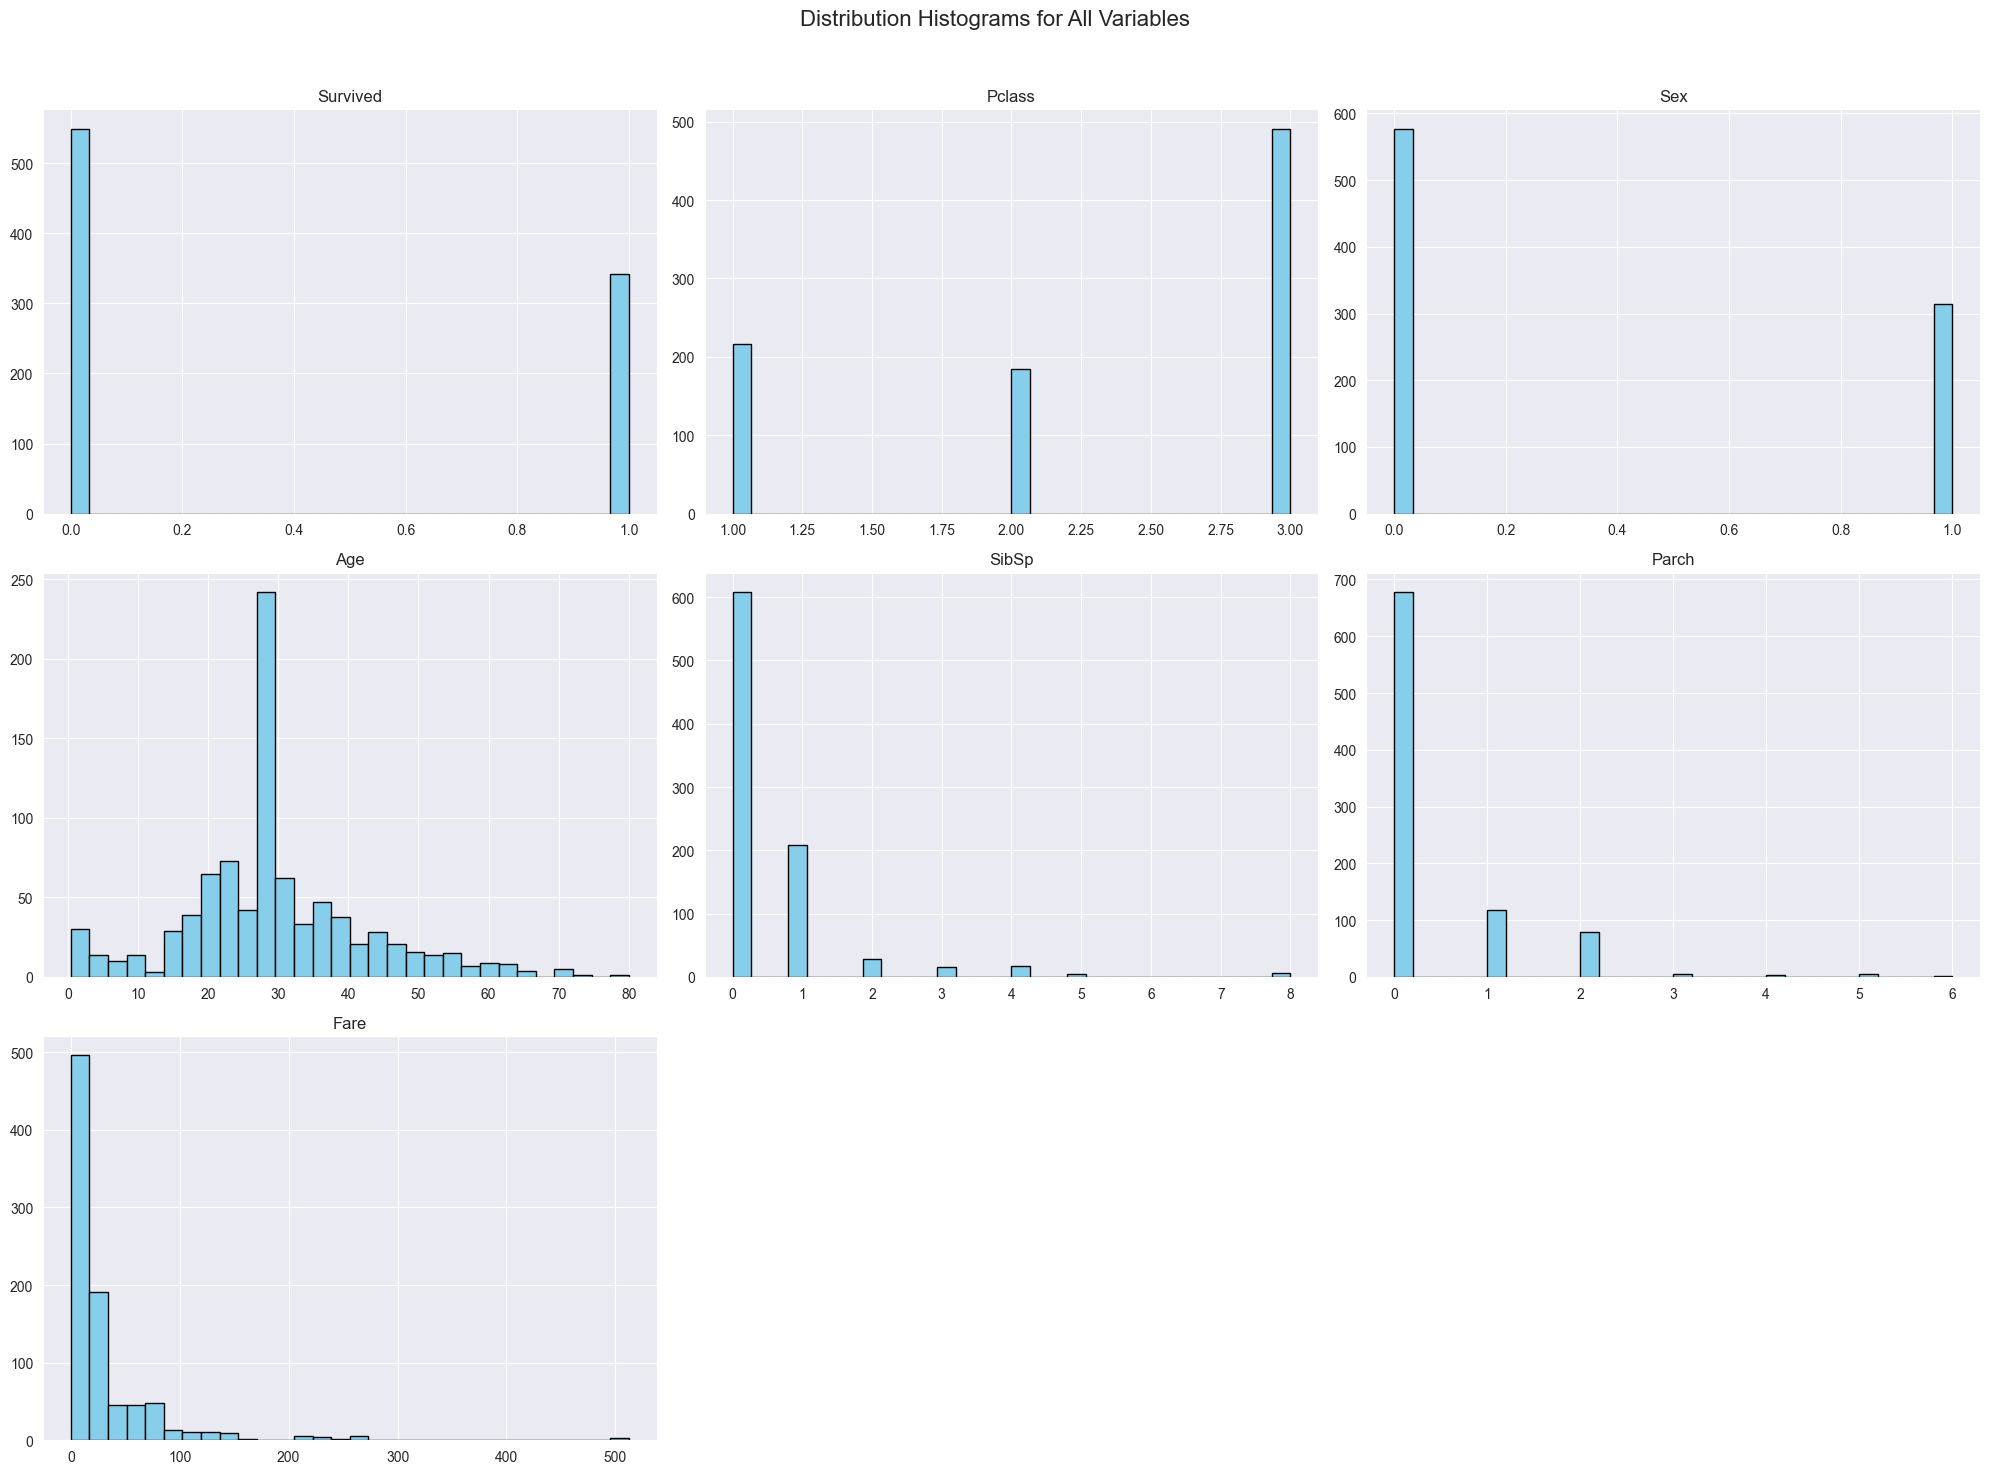

In [488]:
# Plot histograms
train_data.hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')

# Add title and adjust layout
plt.suptitle('Distribution Histograms for All Variables', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


In [489]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Age_Teen,Age_Adult,Age_Senior
0,0,3,0,22.0,1,0,7.2500,False,False,True,False,True,False
1,1,1,1,38.0,1,0,71.2833,True,False,False,False,True,False
2,1,3,1,26.0,0,0,7.9250,False,False,True,False,True,False
3,1,1,1,35.0,1,0,53.1000,False,False,True,False,True,False
4,0,3,0,35.0,0,0,8.0500,False,False,True,False,True,False


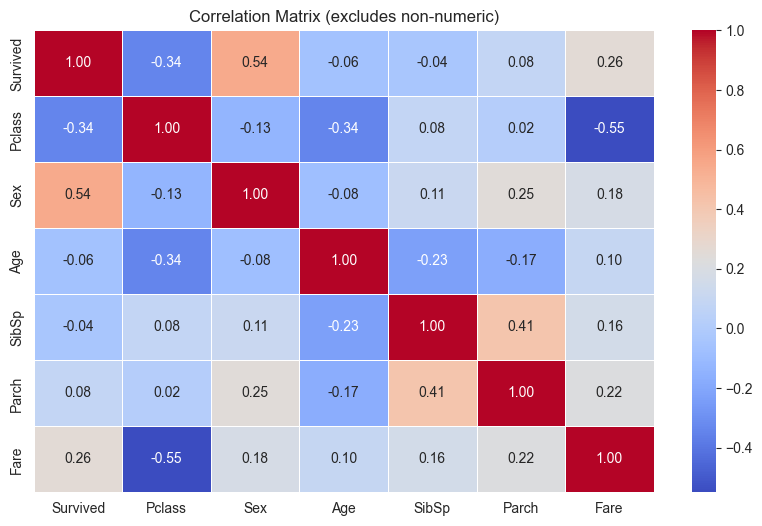

In [490]:
# Ensure numeric_train_data is defined
numeric_train_data = train_data.select_dtypes(include=['number'])  # Select only numeric columns

# Compute correlation matrix
corr_matrix = numeric_train_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix (excludes non-numeric)")
plt.show()


In [491]:
## Random Forest Regressor##

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200,300],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2',None],  # Maximum features considered for splitting
}

# Initialize a Random Forest Regressor and GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, Y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Random Forest Regressor with the best hyperparameters
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, Y_train)

# Make predictions and evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(Y_test, y_pred_tuned)
r2_tuned = r2_score(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:", {
    "Tuned Mean Squared Error": mse_tuned,
    "Tuned R-squared (R2) Score": r2_tuned
})

## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data)  # Generate predictions

# Convert predictions to binary survival values (0 or 1)
test_predictions = np.round(test_predictions).astype(int)  # Round to nearest integer

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Prepare final submission file
final_submission = pd.DataFrame({
    "PassengerId": test_data_id["PassengerId"],  # Ensure PassengerId is included
    "Survived": test_results["Survived"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("rf_submission.csv", index=False)
print("Submission saved to 'rf_submission.csv'")



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters Found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Evaluation Metrics: {'Tuned Mean Squared Error': 0.1382270103059715, 'Tuned R-squared (R2) Score': 0.4303083268367419}
Submission saved to 'rf_submission.csv'


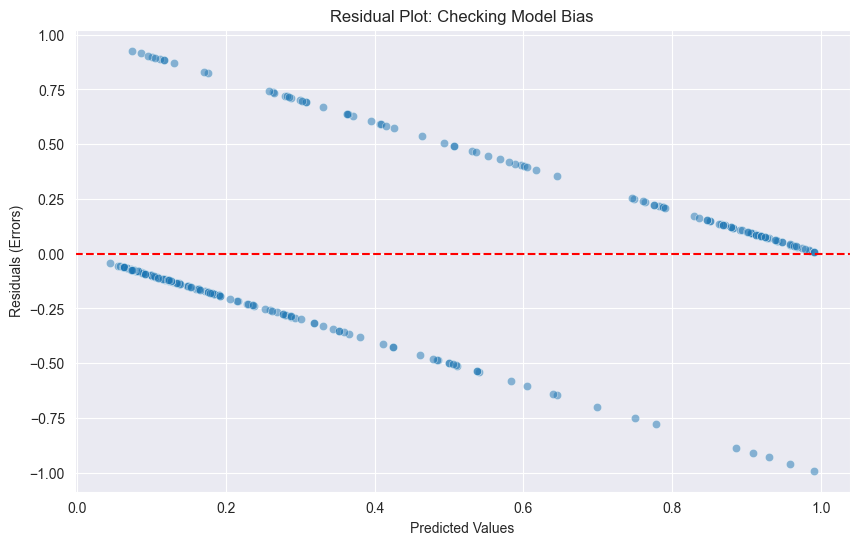

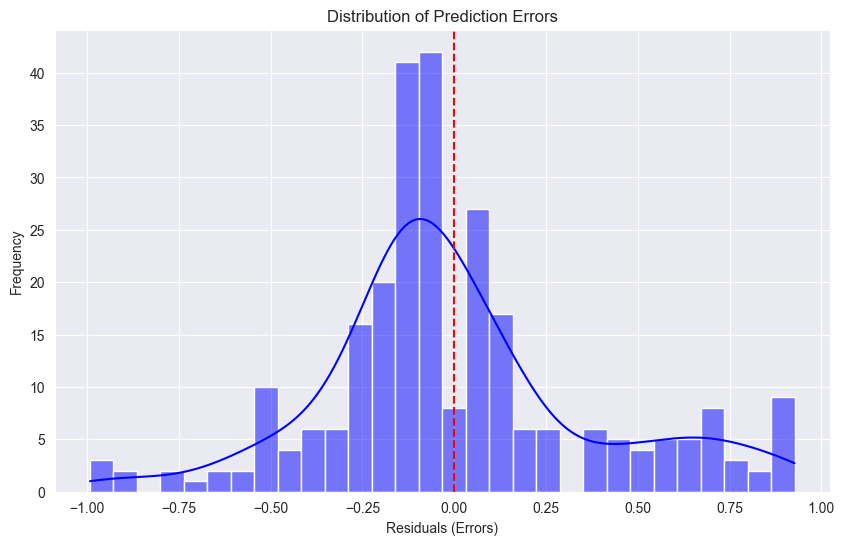

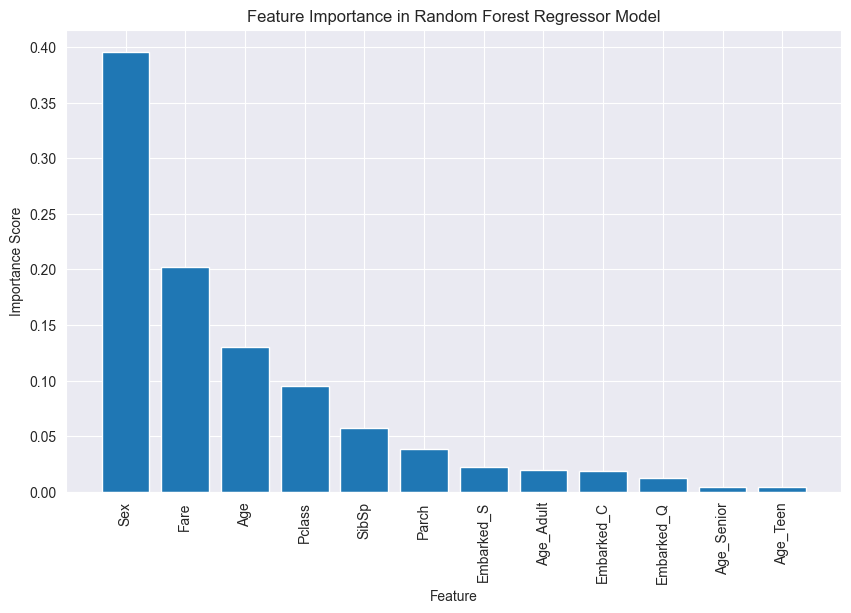

In [492]:
# Evaluation of Random Tree Regressor Model #
# Compute residuals
residuals = Y_test - y_pred_tuned

# Plot 1: Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_tuned, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot: Checking Model Bias")
plt.show()

# Plot 2: Distribution of Errors (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel("Residuals (Errors)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

# Get feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest Regressor Model")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()


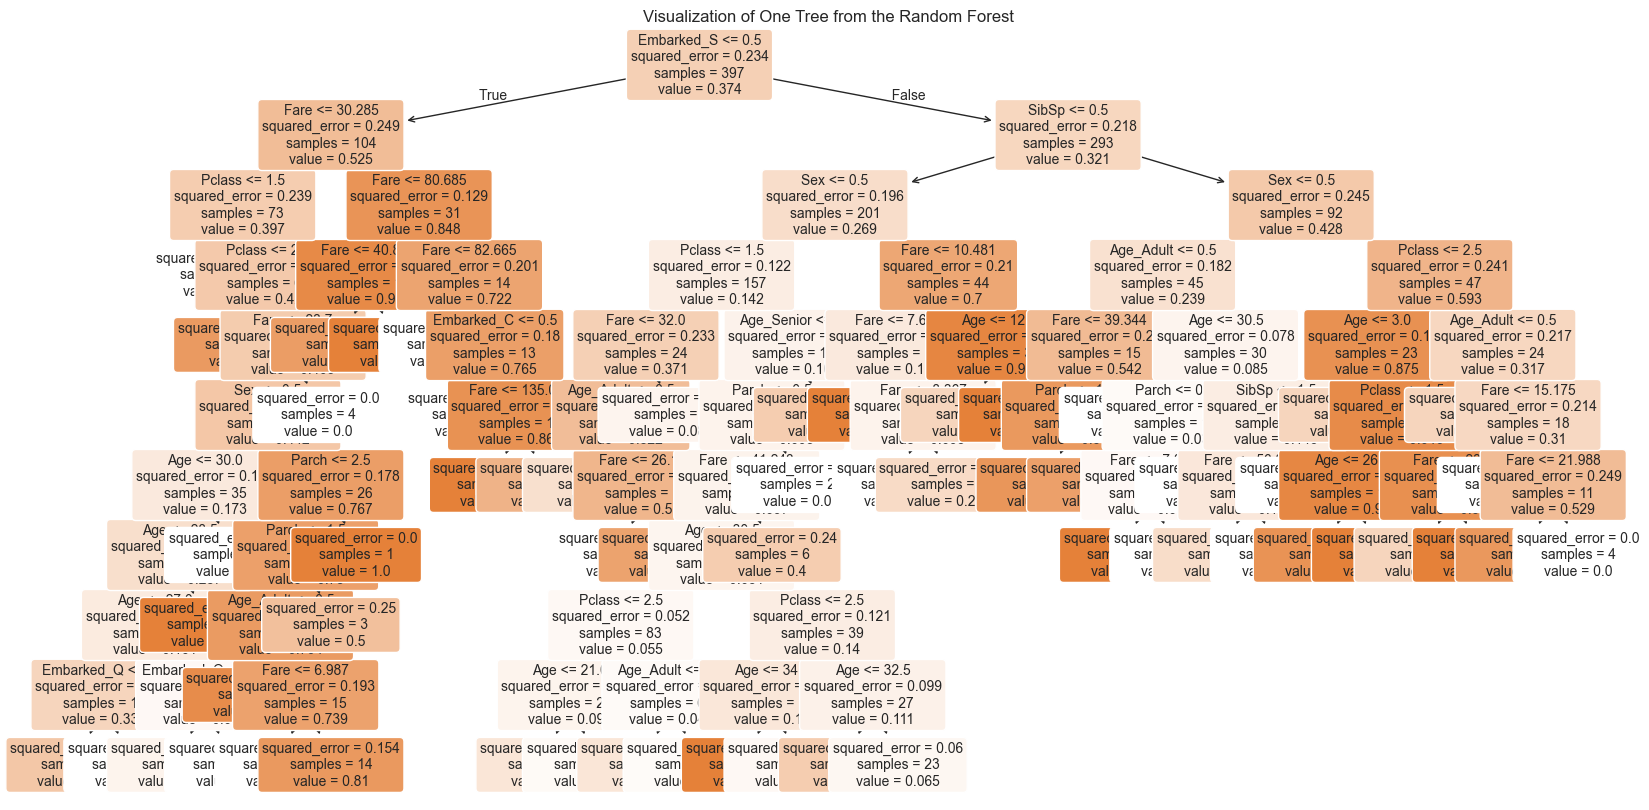

In [493]:
# Visualizing one of the trees in the Random Forest
# Select a tree from the trained Random Forest
random_tree = best_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    random_tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualization of One Tree from the Random Forest")
plt.show()

In [494]:
## Random Forest Classifier Model ##

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Maximum features considered for splitting
    'criterion' : ['gini']
}

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Initialize a Random Forest Classifier and GridSearchCV
rf = RandomForestClassifier(class_weight={0:1, 1:2}, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)

# Perform the grid search on the training data
grid_search.fit(X_train, Y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Random Forest Classifier with the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, Y_train)

# Make predictions and evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)  # Classifier already returns 0 or 1

# Compute Classification Metrics
accuracy = accuracy_score(Y_test, y_pred_tuned)
conf_matrix = confusion_matrix(Y_test, y_pred_tuned)
class_report = classification_report(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data)  # Directly predict class labels (0 or 1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Prepare final submission file
final_submission = pd.DataFrame({
    "PassengerId": test_data_id["PassengerId"],  # Ensure PassengerId is included
    "Survived": test_results["Survived"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("rf_classifier_submission.csv", index=False)  # Updated filename
print("Submission saved to 'rf_classifier_submission.csv'")


Fitting 30 folds for each of 324 candidates, totalling 9720 fits
Best Hyperparameters Found: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Evaluation Metrics:
Accuracy: 0.7985
Confusion Matrix:
 [[140  17]
 [ 37  74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       157
           1       0.81      0.67      0.73       111

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.79       268

Submission saved to 'rf_classifier_submission.csv'


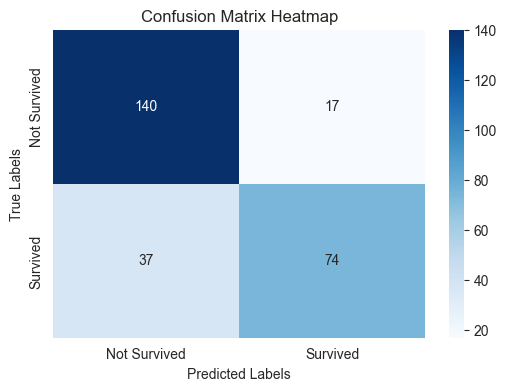

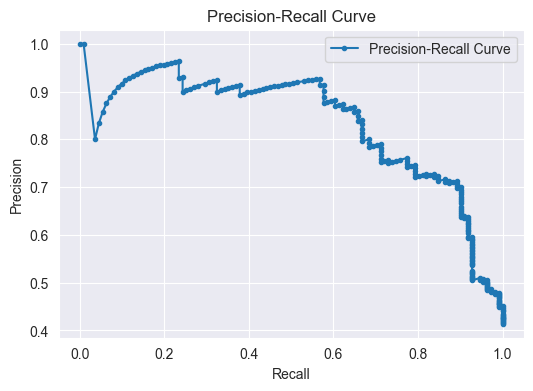

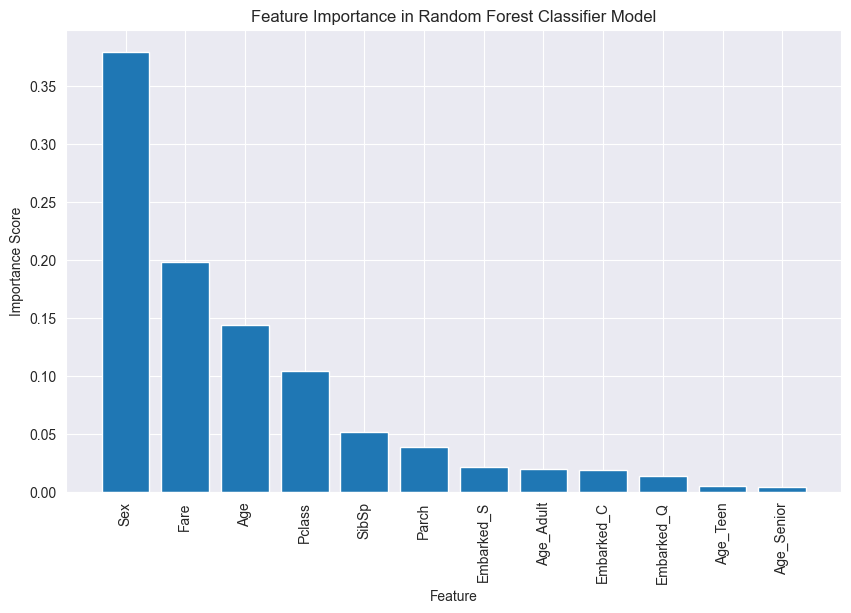

In [495]:
# Additional Evaluation of Random Forest Classifier

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision-Recall Curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probability scores for class 1

precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Get feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest Classifier Model")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [496]:
 ## Gradient Boosted Trees Model ##

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 400],  # Number of boosting rounds
    'max_depth': [3, 5, 10],  # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate for shrinking contributions
    'subsample': [0.8, 1.0],  # Fraction of samples used for training each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt'],  # Maximum features for best split
    'loss': ['log_loss']  # Loss function for boosting
}

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Initialize a Gradient Boosted Trees Classifier and GridSearchCV
gbt = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gbt, param_grid=param_grid,
                           cv=cv, n_jobs=-1, scoring='accuracy', verbose=1)  # Optimizing for accuracy

# Perform the grid search on the training data
grid_search.fit(X_train, Y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Gradient Boosted Trees Classifier with the best hyperparameters
best_model = GradientBoostingClassifier(**best_params, random_state=42)
best_model.fit(X_train, Y_train, sample_weight=Y_train.map({0: 1, 1: 1.5}))  # Increase weight for class 1

# Make predictions and evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)  # Classifier already returns 0 or 1

# Compute Classification Metrics
accuracy = accuracy_score(Y_test, y_pred_tuned)
conf_matrix = confusion_matrix(Y_test, y_pred_tuned)
class_report = classification_report(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data)  # Directly predict class labels (0 or 1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Prepare final submission file
final_submission = pd.DataFrame({
    "PassengerId": test_data_id["PassengerId"],  # Ensure PassengerId is included
    "Survived": test_results["Survived"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("gbt_classifier_submission.csv", index=False)  # Updated filename
print("Submission saved to 'gbt_classifier_submission.csv'")


Fitting 10 folds for each of 486 candidates, totalling 4860 fits
Best Hyperparameters Found: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Evaluation Metrics:
Accuracy: 0.7948
Confusion Matrix:
 [[132  25]
 [ 30  81]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       157
           1       0.76      0.73      0.75       111

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268

Submission saved to 'gbt_classifier_submission.csv'


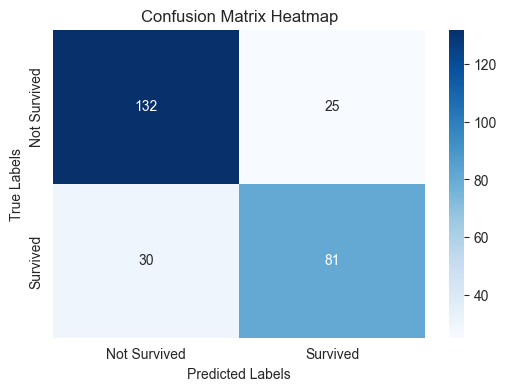

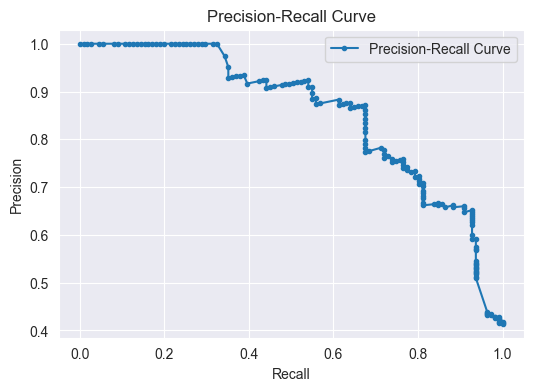

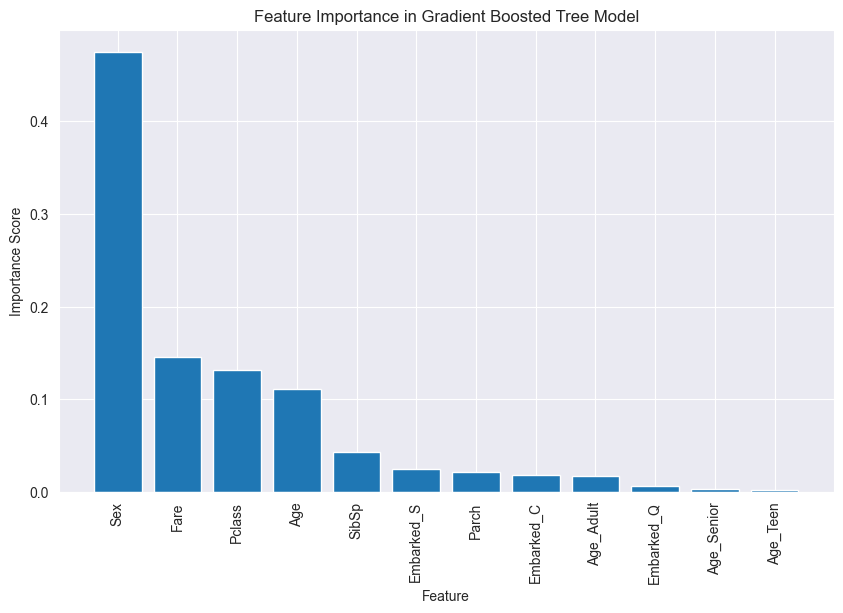

In [497]:
# Additional Evaluation of Gradient Boosted Tree Classifier

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision-Recall Curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probability scores for class 1

precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Get feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Gradient Boosted Tree Model")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [498]:
## Extra Trees ##

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300, 500, 600],  # Number of trees
    'max_depth': [5, 10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features for best split
    'criterion': ['gini', 'entropy'],  # Splitting criterion
    'bootstrap': [True, False]  # Whether to use bootstrapping
}

# Initialize Extra Trees Classifier and GridSearchCV
etc = ExtraTreesClassifier(random_state=42)
grid_search = GridSearchCV(estimator=etc, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)  # Optimizing for accuracy

# Perform the grid search on the training data
grid_search.fit(X_train, Y_train)

# Extract the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters Found:", best_params)

# Train the Extra Trees Classifier with the best hyperparameters
best_model = ExtraTreesClassifier(**best_params, random_state=42)
best_model.fit(X_train, Y_train)

# Make predictions and evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)  # Classifier already returns 0 or 1

# Compute Classification Metrics
accuracy = accuracy_score(Y_test, y_pred_tuned)
conf_matrix = confusion_matrix(Y_test, y_pred_tuned)
class_report = classification_report(Y_test, y_pred_tuned)

# Output the best hyperparameters and evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

## Predict using the TEST Data ##
test_predictions = best_model.predict(test_data)  # Directly predict class labels (0 or 1)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Prepare final submission file
final_submission = pd.DataFrame({
    "PassengerId": test_data_id["PassengerId"],  # Ensure PassengerId is included
    "Survived": test_results["Survived"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("extra_trees_classifier_submission.csv", index=False)  # Updated filename
print("Submission saved to 'extra_trees_classifier_submission.csv'")



Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Hyperparameters Found: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Evaluation Metrics:
Accuracy: 0.8134
Confusion Matrix:
 [[146  11]
 [ 39  72]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       157
           1       0.87      0.65      0.74       111

    accuracy                           0.81       268
   macro avg       0.83      0.79      0.80       268
weighted avg       0.82      0.81      0.81       268

Submission saved to 'extra_trees_classifier_submission.csv'


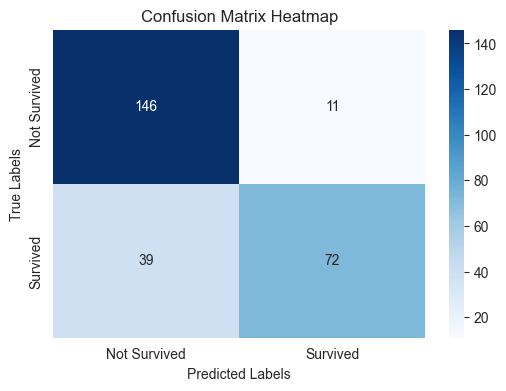

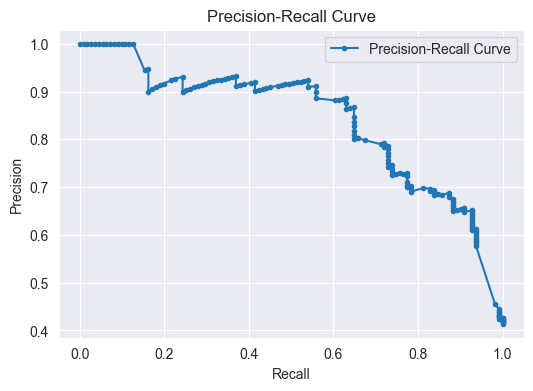

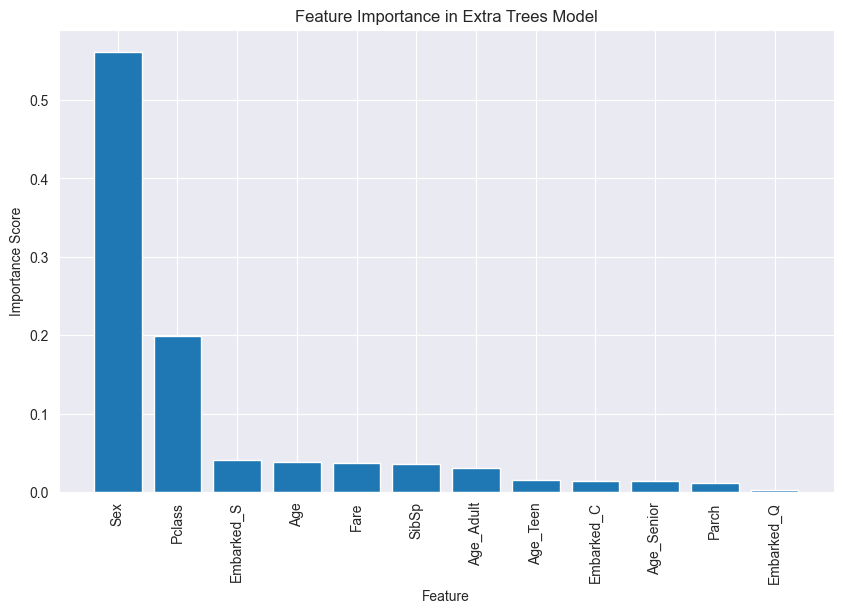

In [499]:
# Additional Evaluation of Extra Trees Classifier

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Precision-Recall Curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probability scores for class 1

precision, recall, _ = precision_recall_curve(Y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Get feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Extra Trees Model")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()